# 6주차 실습: `torchvision`과 FCN 모델로 세그멘테이션

- **학습 목표:**
  1. `torchvision`을 이용해 Oxford-IIIT Pet 데이터셋을 불러온다.
  2. 세그멘테이션의 기초 모델인 **CNN 기반 FCN(완전 합성곱 신경망)**의 구조를 이해하고 직접 구현한다.
  3. 직접 만든 FCN 모델을 훈련시키고, 예측 결과를 시각화하여 분할 성능을 확인한다.

### STEP 0: 환경 준비

Colab 메뉴에서 **[런타임] > [런타임 유형 변경]**을 선택하고, 하드웨어 가속기를 **GPU**로 설정하세요.

### STEP 1: 라이브러리 Import 및 기본 설정

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

DATA_PATH = "./pet_data"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {DEVICE}")

Device: cuda


### STEP 2: Oxford-IIIT Pet 데이터셋 준비

`torchvision`을 통해 반려동물과 배경을 분할하는 데이터셋을 다운로드합니다. 이 데이터셋의 마스크는 **1(반려동물), 2(배경), 3(경계선)** 세 개의 클래스로 구성됩니다. 실습에서는 이를 **1(반려동물)과 0(배경)**으로 이진화하여 더 간단한 문제로 만듭니다.

In [2]:
# --- 이미지와 마스크에 적용할 변환(Transform) 정의 ---
# 입력 이미지는 정규화를 수행합니다.
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 마스크는 텐서로 변환하기만 합니다.
mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

# --- 데이터셋 다운로드 ---
# 'target_types'를 'segmentation'으로 설정해야 마스크 데이터를 받을 수 있습니다.
train_dataset_full = OxfordIIITPet(root=DATA_PATH, split='trainval', target_types='segmentation', download=True,
                                   transform=image_transform, target_transform=mask_transform)

# 실습을 위해 500개 샘플만 사용
train_dataset = Subset(train_dataset_full, range(500))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(f"✔️ 데이터셋 준비 완료! {len(train_dataset)}개의 샘플을 훈련에 사용합니다.")

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_9372\1888128067.py:11: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  transforms.Resize((224, 224), interpolation=Image.NEAREST),


100%|███████████████████████████████████████████████████████████████| 791918971/791918971 [12:01<00:00, 1096935.37it/s]


Extracting pet_data\oxford-iiit-pet\images.tar.gz to pet_data\oxford-iiit-pet


100%|█████████████████████████████████████████████████████████████████| 19173078/19173078 [00:07<00:00, 2462579.72it/s]


Extracting pet_data\oxford-iiit-pet\annotations.tar.gz to pet_data\oxford-iiit-pet
✔️ 데이터셋 준비 완료! 500개의 샘플을 훈련에 사용합니다.


### STEP 3: SimpleFCN 모델 및 훈련 준비

모델은 `SimpleFCN`을 사용하되, **출력 클래스 개수(`n_class`)와 손실 함수**를 이번 과제에 맞게 변경합니다.

In [3]:
# --- 모델 정의 (이전과 동일) ---
class SimpleFCN(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2), nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, n_class, kernel_size=2, stride=2)
        )
    def forward(self, x):
        x = self.encoder(x); return self.decoder(x)

#  n_class=1: 반려동물(1)과 배경(0)을 구분하는 이진(Binary) 문제이므로 출력 채널은 1개
model = SimpleFCN(n_class=1).to(DEVICE)

# criterion: 출력 채널이 1개인 이진 분류에는 BCEWithLogitsLoss를 사용
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()

print("✔️ 모델 및 훈련 설정 완료!")

✔️ 모델 및 훈련 설정 완료!


### STEP 4: 모델 훈련시키기

In [4]:
# --- 기본 설정 ---
LEARNING_RATE = 0.001
BATCH_SIZE = 16
EPOCHS = 20

print("--- 훈련 시작 ---")
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    for images, masks in train_loader:
        images = images.to(DEVICE)
        # 마스크 값을 0 또는 1로 이진화 (1:Pet, 0:Background/Boundary)
        masks[masks > 1] = 0
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.float()) # BCE Loss는 float 타입의 타겟을 요구
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {epoch_loss/len(train_loader):.4f}")
print("--- 훈련 종료 ---")


--- 훈련 시작 ---
Epoch [1/20], Loss: 0.1921
Epoch [2/20], Loss: 0.0524
Epoch [3/20], Loss: 0.0463
Epoch [4/20], Loss: 0.0440
Epoch [5/20], Loss: 0.0431
Epoch [6/20], Loss: 0.0428
Epoch [7/20], Loss: 0.0428
Epoch [8/20], Loss: 0.0428
Epoch [9/20], Loss: 0.0429
Epoch [10/20], Loss: 0.0428
Epoch [11/20], Loss: 0.0429
Epoch [12/20], Loss: 0.0427
Epoch [13/20], Loss: 0.0428
Epoch [14/20], Loss: 0.0428
Epoch [15/20], Loss: 0.0428
Epoch [16/20], Loss: 0.0428
Epoch [17/20], Loss: 0.0428
Epoch [18/20], Loss: 0.0427
Epoch [19/20], Loss: 0.0427
Epoch [20/20], Loss: 0.0427
--- 훈련 종료 ---


### STEP 5: 결과 시각화

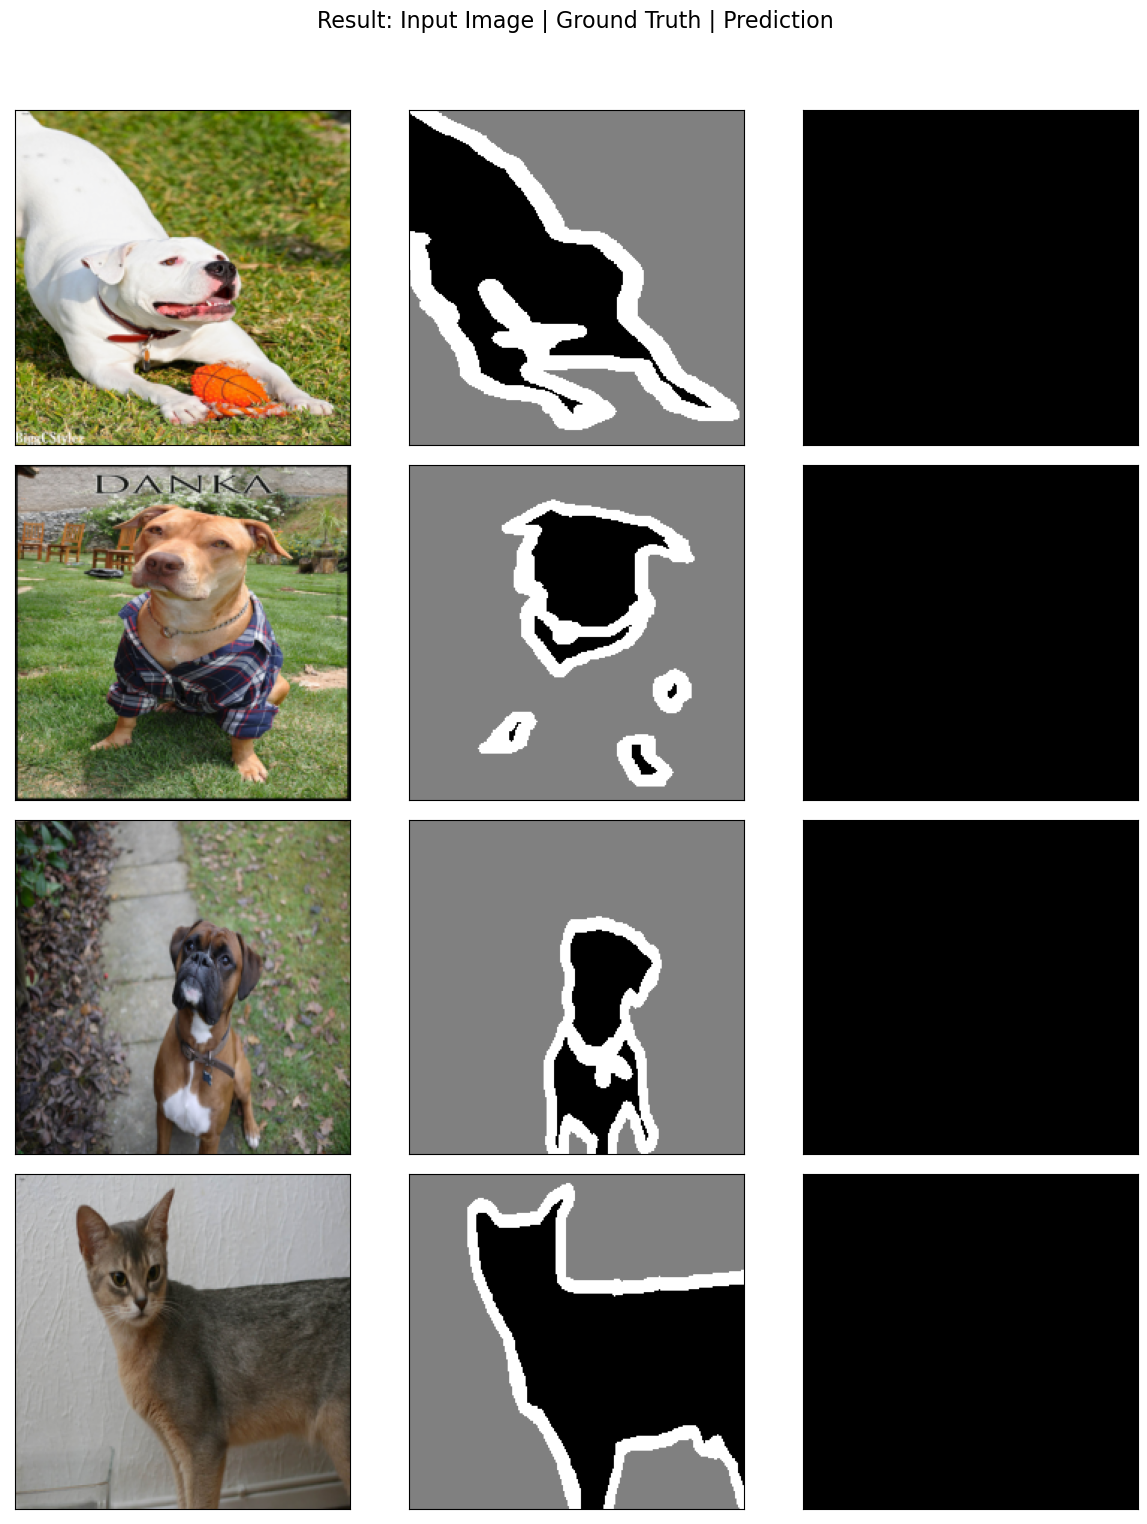

In [5]:
# --- 결과 시각화 ---
model.eval()
with torch.no_grad():
    images, masks = next(iter(train_loader))
    images, masks = images.to(DEVICE), masks.to(DEVICE)
    masks[masks > 1] = 0 # 시각화를 위해 마스크 이진화
    
    outputs = model(images)
    preds = torch.sigmoid(outputs) > 0.5 # Sigmoid와 0.5 임계값으로 이진 마스크 생성
    
    fig, axs = plt.subplots(4, 3, figsize=(12, 16))
    fig.suptitle("Result: Input Image | Ground Truth | Prediction", fontsize=16)
    for i in range(min(4, BATCH_SIZE)):
        img = images[i].cpu().numpy().transpose(1, 2, 0)
        mean, std = np.array([0.485,0.456,0.406]), np.array([0.229,0.224,0.225])
        img = std * img + mean; img = np.clip(img, 0, 1)
        axs[i, 0].imshow(img)
        
        axs[i, 1].imshow(masks[i].cpu().squeeze(), cmap='gray')
        axs[i, 2].imshow(preds[i].cpu().squeeze(), cmap='gray')
        
        for ax in axs[i]: ax.set_xticks([]), ax.set_yticks([])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()